In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import sys
sys.path.append('/home/henry/Downloads/Github/heston-moments-pdf/simulation')

from simulation.utils import process_to_log_returns_interday, process_to_log_returns
from simulation.SimHestonQE import Heston_QE
from code_from_haozhe.RealizedMomentsEstimator_Aggregate_update import rMoments_mvsek, RM_CL, RM_NP, RM_ORS, RM_ACJV, RM_NP_return
from code_from_haozhe.RealizedMomentsEstimator_MonthOverlap import RM_NP_return, rMoments as rMoments_mvsek_month
from code_from_haozhe.RealizedSkewness_NP_MonthlyOverlap import rCumulants
from expansion_methods.all_methods import scipy_mvsek_to_cumulants, gram_charlier_expansion, edgeworth_expansion, saddlepoint_approximation
from code_from_haozhe.GramCharlier_expansion import Expansion_GramCharlier as gram_charlier_expansion_haozhe
from heston_model_properties.theoretical_density import compute_density_via_ifft_accurate

from code_from_haozhe.GramCharlier_expansion import Expansion_GramCharlier
from code_from_haozhe.HestonDensity_FFT import HestonChfDensity_FFT_Gatheral

np.random.seed(0)

In [34]:
time_points = 60 * 22 * 12
time_points = 15 * 22 * 79 * 12
start_date = '2014-07-01'
end_date = '2076-07-01'
T = 60
T = 15
S0 = 100
paths = 1
v0 = 0.19
kappa = 3
theta = 0.19
sigma = 0.4
mu = 0 # martingale
rho = -0.7
rolling_window = 22

In [40]:
print(f'Feller condition: {2 * kappa * theta > sigma**2}')

# Simulation
process = Heston_QE(S0=S0, v0=v0, kappa=kappa, theta=theta, sigma=sigma, mu=mu, rho=rho, T=T, N=time_points, n_paths=paths)
if mu != 0:
    # de-mean the data
    process = process - mu
process_df = process_to_log_returns_interday(process, start_date, end_date, burnin_timesteps=3 * 22 * 79 * 12)
# process_df = process_to_log_returns(process, start_date, end_date, time_points)

# Estimate moments
technique = RM_NP_return
mvsek = []
realized_cumulants = []
for column in process_df.columns:
    mvsek.append(rMoments_mvsek(process_df[column], method=technique, days_aggregate=rolling_window, m1zero=True, ret_nc_mom=True).to_numpy())
    realized_cumulants.append(rCumulants(process_df[column], method=technique, months_overlap=6).to_numpy())
mvsek = np.squeeze(np.array(mvsek))
realized_cumulants = np.squeeze(np.array(realized_cumulants))
mvsek = pd.DataFrame(mvsek).T # each column is a path and each row is a moment (mean, variance, 3rd moment, 4th moment, skewness, excess kurtosis)
realized_cumulants = pd.DataFrame(realized_cumulants).T
# print(mvsek)
# print(realized_cumulants)
mvsek = mvsek.mean(axis=1) # rowwise means
realized_cumulants = realized_cumulants.mean(axis=1)
print(mvsek)
print(realized_cumulants)

Feller condition: True
0   -0.022089
1    0.016148
2   -0.000787
3    0.000961
4   -0.178645
5    3.311072
dtype: float64
0   -0.022422
1    0.015986
2   -0.000780
3    0.000946
dtype: float64


In [5]:
x_density, density = compute_density_via_ifft_accurate(mu=mu, kappa=kappa, theta=theta, sigma=sigma, rho=rho, t=1/12)

In [6]:
f_x = HestonChfDensity_FFT_Gatheral(mu = 0, kappa = 3, theta = 0.19, sigma = 0.4, rho=-0.7, lambdaj=0, muj=0, vj=0, t = 1/12, v0 = 0.19, conditional=False)

In [41]:
cumulants = scipy_mvsek_to_cumulants(mean=mvsek[0], variance=mvsek[1], skewness=mvsek[4], excess_kurtosis=mvsek[5])
cumulants2 = (mvsek[0], mvsek[1], mvsek[2]*3, mvsek[3])
cumulants_true = (-0.00791667, 0.01601168, -0.00056375, 0.00088632)
cumulants_haozhe = (-0.01401158, 0.01647651, -0.0006112, 0.00093973)
realized_cumulants = (realized_cumulants[0], realized_cumulants[1], realized_cumulants[2], realized_cumulants[3])

In [26]:
print(cumulants)
print(cumulants2)
print(realized_cumulants)

(0.0036829811345818115, 0.013828692527015558, 0.0003595231442509949, 0.0007384352924259058)
(0.0036829811345818115, 0.013828692527015558, -0.0006476669492545136, 0.0008552638560680836)
(0.0037070350589639115, 0.013725426169551117, -0.00021227694447318557, 0.000851354824672894)


In [46]:

x = np.linspace(-2, 2, 1000)
gc = gram_charlier_expansion(x, *cumulants, fakasawa=True)
gc2 = gram_charlier_expansion(x, *cumulants2, fakasawa=True) # fakasawa=True is needed but only works for HF data!
gc_true = gram_charlier_expansion(x, *cumulants_true, fakasawa=True)
gc_haozhe = gram_charlier_expansion(x, *cumulants_haozhe, fakasawa=True)

gc_realized_cumulants = gram_charlier_expansion(x, *realized_cumulants, fakasawa=True)

haozhe_gc = gram_charlier_expansion_haozhe(cumulants)
haozhe_gc2 = gram_charlier_expansion_haozhe(cumulants2)
haozhe_gc_true = gram_charlier_expansion_haozhe(cumulants_true)
haozhe_gc_haozhe = gram_charlier_expansion_haozhe(cumulants_haozhe)

In [14]:
true_cumulant = np.array([-0.00791667, 0.01601168, -0.00056375, 0.00088632])
f_true_x = Expansion_GramCharlier(true_cumulant)

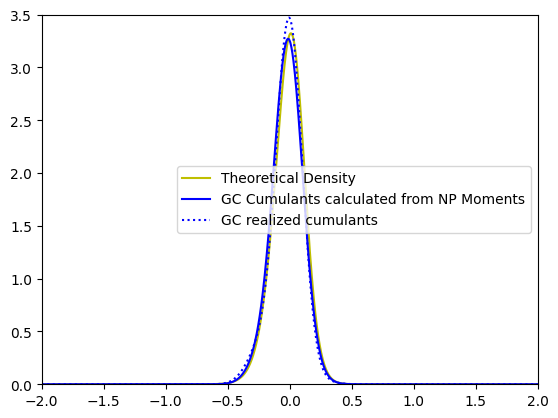

In [48]:
plt.plot(x_density, density, 'y-', label='Theoretical Density')
# plt.plot(x, f_x, label=r'$f(x)$', linestyle='-.', color='blue', linewidth=2)
# plt.plot(x, f_true_x, label=r'$\tilde{f}(x) using\ true\ cumulants$', linestyle='-', color='red', linewidth=2)

plt.plot(x, gc, 'b-', label='GC Cumulants calculated from NP Moments')
# plt.plot(x, gc2, 'r-', label='GC Cumulants = Central Moments')
# plt.plot(x, gc_true, 'm-', label='GC True Cumulants')
# plt.plot(x, gc_haozhe, 'g-', label='GC Haozhe Cumulants (realized cumulant method)')

plt.plot(x, gc_realized_cumulants, 'b:', label='GC realized cumulants')

# plt.plot(x, haozhe_gc, 'b--', label='HaozheGC Cumulants calculated from NP Moments')
# plt.plot(x, haozhe_gc2, 'r--', label='HaozheGC Cumulants = Central Moments')
# plt.plot(x, haozhe_gc_true, 'm--', label='HaozheGC True Cumulants')
# plt.plot(x, haozhe_gc_haozhe, 'g--', label='HaozheGC Haozhe Cumulants (realized cumulant method)')

plt.legend()

# plt.tight_layout()
plt.ylim(0, 3.5)
plt.xlim(-2, 2)
plt.show()